In [1]:
# ref: https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html
# ref: https://arxiv.org/abs/1511.04497

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from astropy.io import fits
from astropy.stats import BoxLeastSquares, LombScargle
from astropy import constants, units

import pymc3 as pm
import pymc3.distributions.transforms as tr

import theano
import theano.tensor as tt

import exoplanet
from exoplanet import distributions
from exoplanet.gp import terms, GP

import lightkurve
from lightkurve import search_targetpixelfile

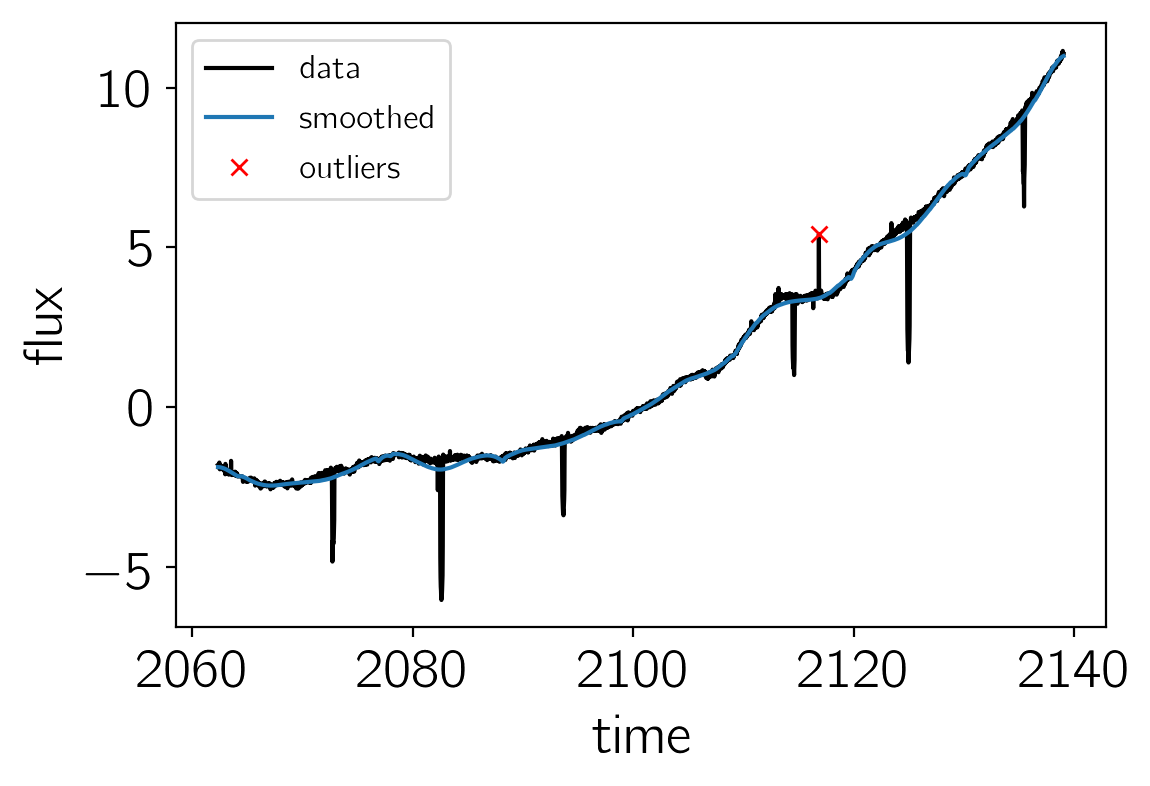

In [2]:
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header
    
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])

bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

smooth = savgol_filter(y, 501, polyorder=5)
resid = y - smooth
sigma = np.sqrt(np.mean(resid**2))
m = resid < 3 * sigma

plt.plot(x, y, "k", label="data")
plt.plot(x, smooth, label="smoothed")
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlabel("time")
plt.ylabel("flux")

x_ref = np.min(x[m])
x = np.ascontiguousarray(x[m], dtype=np.float64)
x -= x_ref
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = savgol_filter(y, 501, polyorder=5)

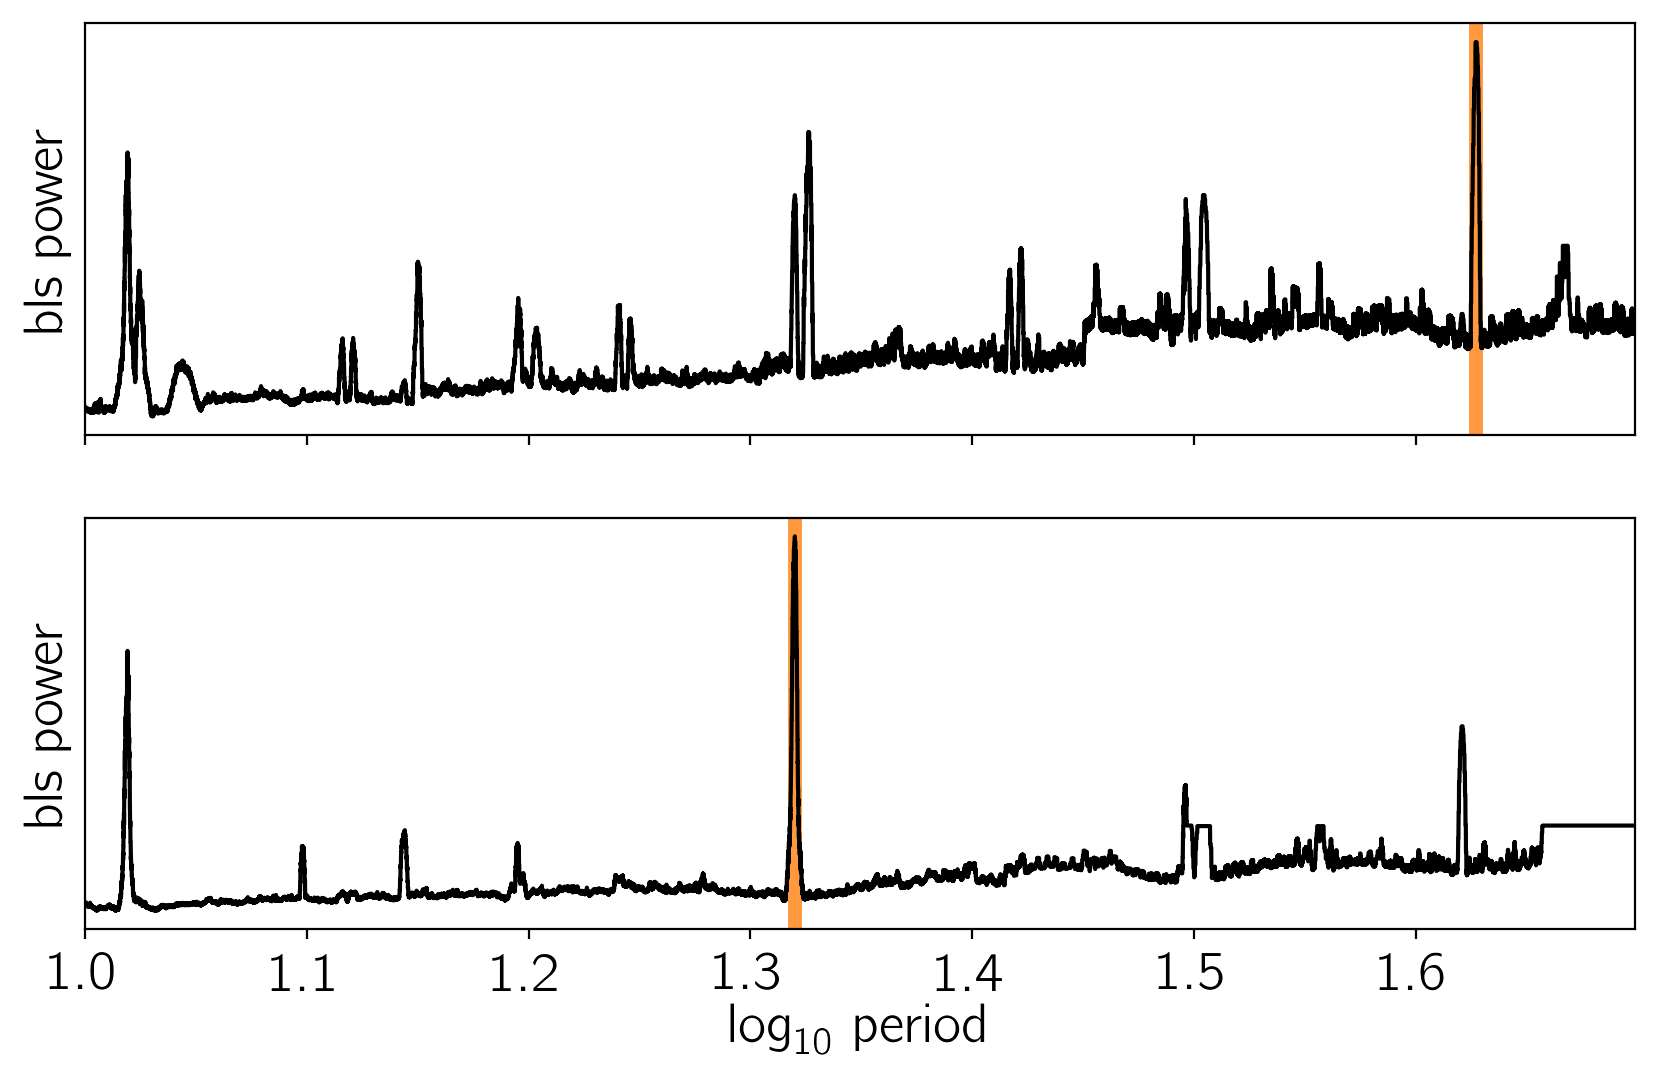

In [3]:
m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(10), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])
    
fig, axes = plt.subplots(len(bls_results), 1, figsize=(10, 6), sharex=True)

for i in range(len(bls_results)):
    ax = axes[i]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    
ax = axes[-1]
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("$\log_{10}$ period");

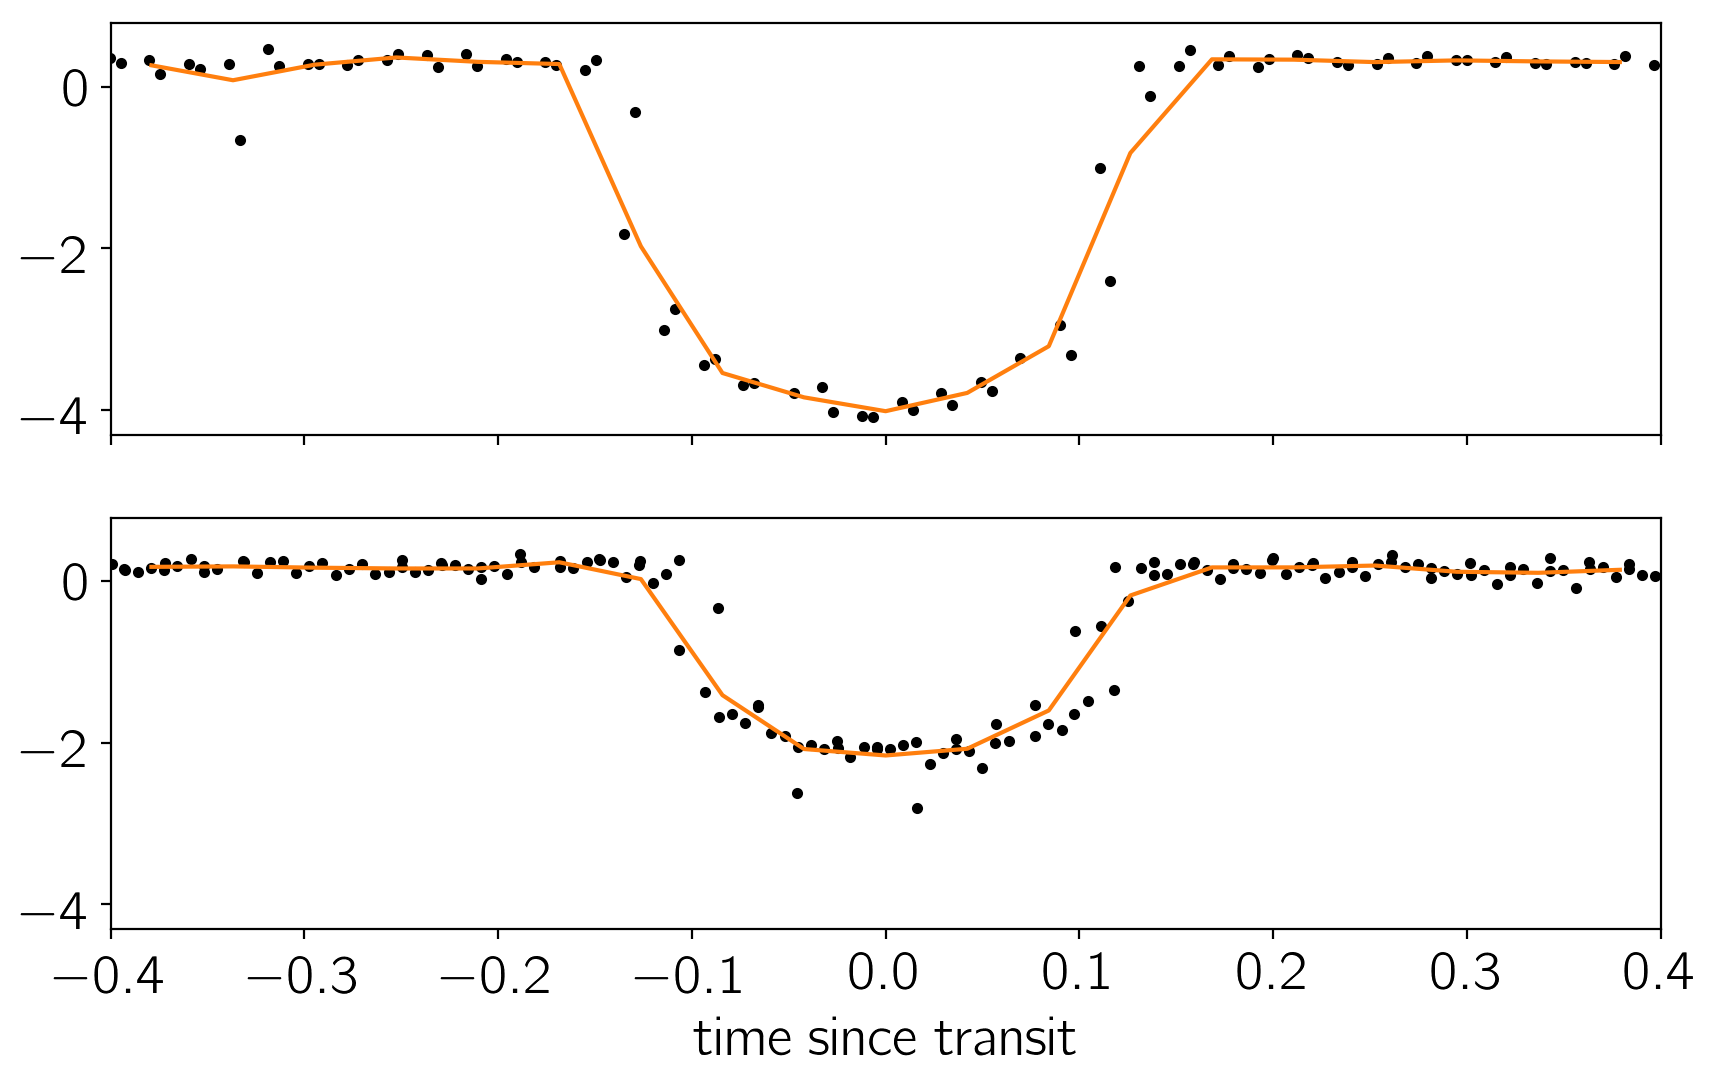

In [4]:
fig, axes = plt.subplots(len(bls_results), 1, figsize=(10, 6), sharex=True)

for i in range(len(bls_results)):
    ax = axes[i]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p    
    ax.plot(x_fold, y - smooth, ".k")
    
    bins = np.linspace(-0.4, 0.4, 20)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")
    
ax = axes[-1]
ax.set_xlim(-0.4, 0.4)
ax.set_xlabel("time since transit");

In [18]:
N_planets = len(periods)

def build_model(mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=1.0)
        u = distributions.Triangle("u", shape=2)
        mstar = pm.Bound(pm.Normal, lower=0.0)("mstar", mu=1.12, sd=0.05)
        rstar = pm.Bound(pm.Normal, lower=0.0)("rstar", mu=1.21, sd=0.11)

        t0 = pm.Normal("t0", mu=t0s, sd=0.1, shape=N_planets)
        logperiod = pm.Normal("logperiod", mu=np.log(periods), sd=1e-4, shape=N_planets)
        period = pm.Deterministic("period", tt.exp(logperiod))

        # Radius/impact parameter joint distribution
        rb_test = 0.5 + np.zeros((2, N_planets))
        rb_test[0, :] = np.sqrt(1e-3)*np.sqrt(depths)
        rb = distributions.RadiusImpactParameter(
            "rb", min_radius=0.01, max_radius=0.1,
            shape=(2, N_planets), testval=rb_test)
        ror = pm.Deterministic("ror", rb[0])
        r = pm.Deterministic("r", ror * rstar)
        b = pm.Deterministic("b", rb[1])

        # Log-uniform prior on r
        pm.Potential("logrprior", -tt.log(r))

        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, shape=N_planets,
                      testval=np.array([0.1, 0.1]))
        omega = distributions.Angle("omega", shape=N_planets)

        # Set up the orbit
        orbit = exoplanet.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            r_star=rstar,
            m_star=mstar,
        )

        lc = exoplanet.StarryLightCurve(u, r_star=rstar)
        transits = lc.get_light_curve(r, orbit, x[mask], texp=texp, oversample=5, order=2)
        transit = tt.sum(transits, axis=-1) * 1e3
        pm.Deterministic("transit", transit)

        # Likelihood
        logs2 = pm.Normal("logs2", mu=-5.0, sd=5.0)
        logw0 = pm.Normal("logw0", mu=0.0, sd=5.0)
        logQ = pm.Normal("logQ", mu=1.0, sd=5.0)
        delta = pm.Normal("delta", mu=0.0, sd=10.0)
        logS0 = pm.Deterministic("logS0", delta - logw0 - logQ)

        kernel = terms.SHOTerm(S0=tt.exp(logS0), w0=tt.exp(logw0), Q=tt.exp(logQ))

        gp = GP(kernel, x[mask], tt.exp(logs2) + np.zeros_like(x[mask]), J=2)

        resid = y[mask] - transit - mean
        pm.Potential("obs", gp.log_likelihood(resid))

        gp_pred = gp.predict()
        pm.Deterministic("gp", mean + gp_pred)
        pm.Deterministic("resid", resid - gp_pred)

        soln = pm.find_MAP(start=model.test_point, vars=[logs2, logS0, logw0, logQ, mean])
        soln = pm.find_MAP(start=soln, vars=[logperiod, t0])
        soln = pm.find_MAP(start=soln)
        
    return model, soln
    
model0, soln0 = build_model()

logp = 2,538.2, ||grad|| = 0.30819: 100%|██████████| 29/29 [00:00<00:00, 57.65it/s]  
logp = 3,004.3, ||grad|| = 692.73: 100%|██████████| 54/54 [00:01<00:00, 41.96it/s]  
logp = 4,839.4, ||grad|| = 6,068: 100%|██████████| 695/695 [00:17<00:00, 39.84it/s] 


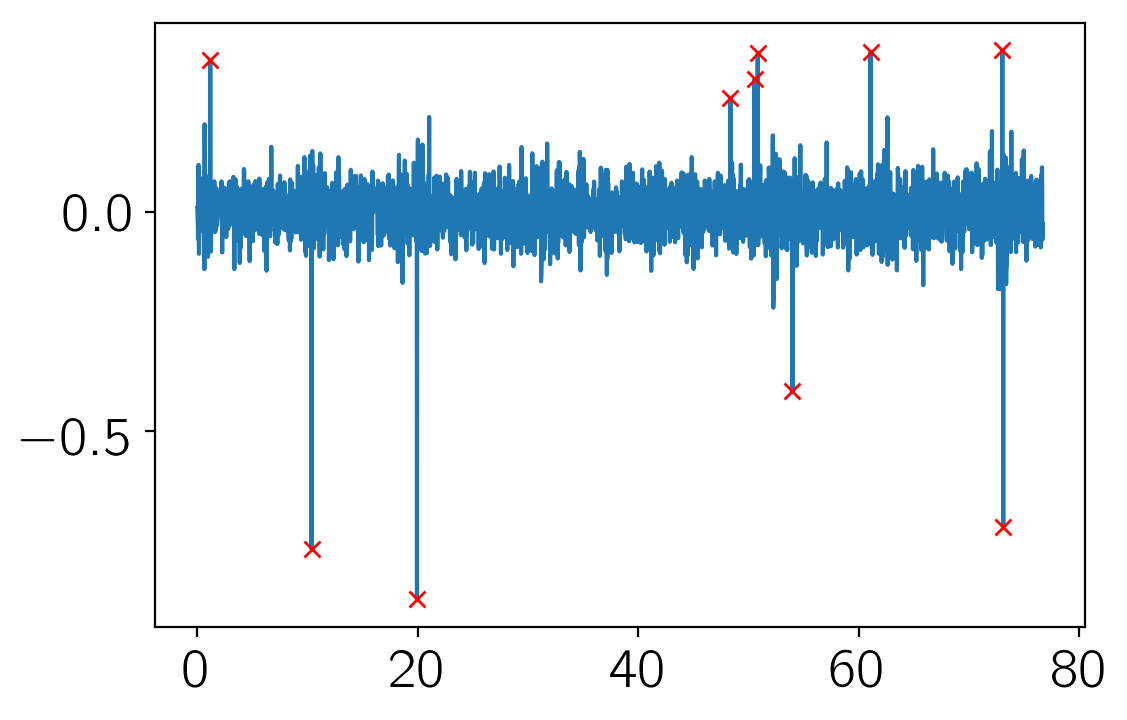

In [6]:
with model0:
    # Sigma clipping
    resid = exoplanet.utils.eval_in_model(model0.resid, soln0)
    sigma = np.sqrt(np.mean(resid**2))
    mask = np.abs(resid) < 4 * sigma
    
    plt.plot(x, resid)
    plt.plot(x[~mask], resid[~mask], "xr")

In [7]:
model, soln = build_model(mask)

logp = 2,607.9, ||grad|| = 0.0023071: 100%|██████████| 42/42 [00:00<00:00, 59.56it/s]
logp = 3,120, ||grad|| = 663.87: 100%|██████████| 35/35 [00:00<00:00, 50.02it/s]  
logp = 5,311.1, ||grad|| = 545.25: 100%|██████████| 471/471 [00:11<00:00, 39.94it/s] 


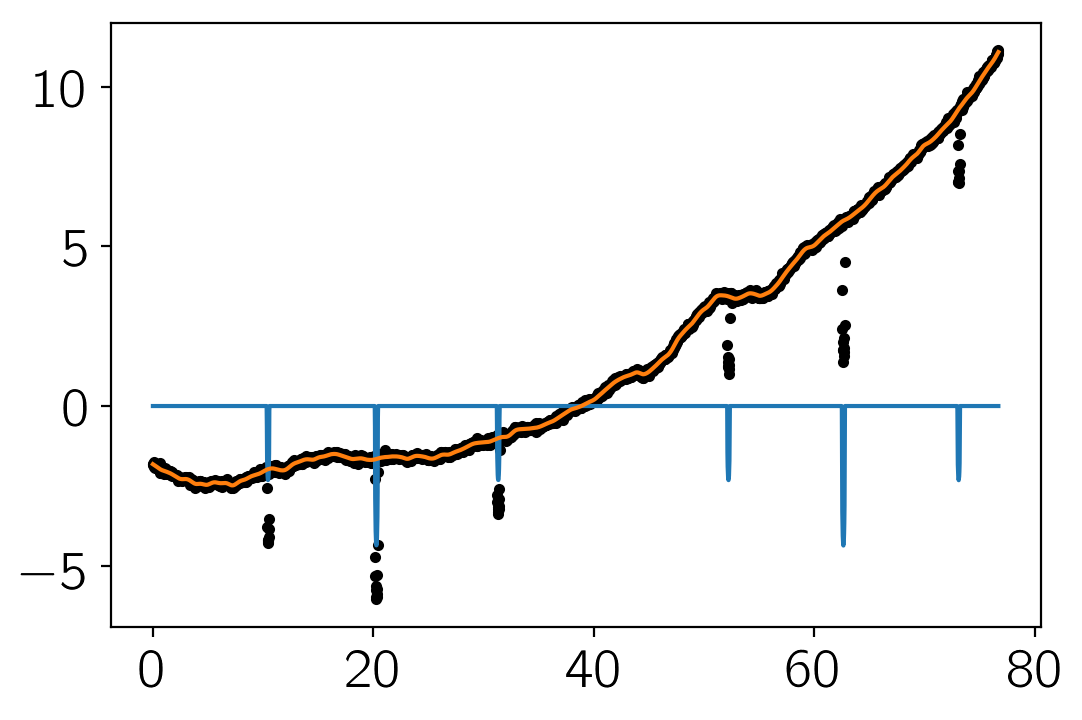

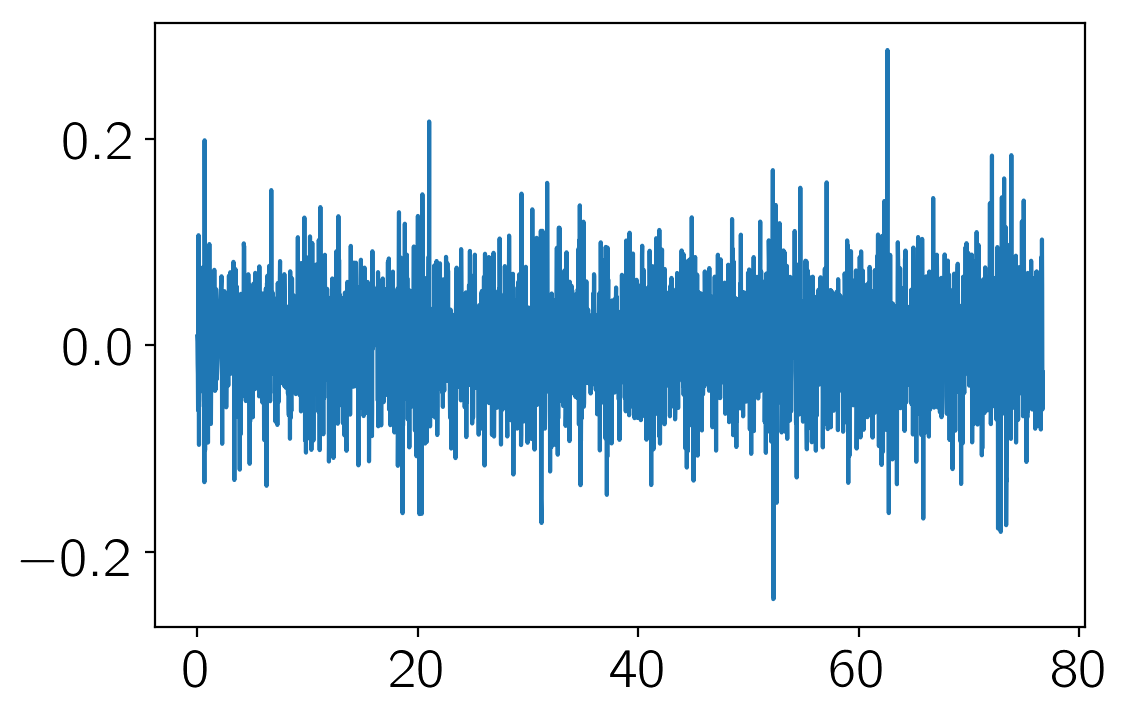

In [8]:
with model:
    plt.plot(x[mask], y[mask], ".k")
        
    plt.plot(x[mask], exoplanet.utils.eval_in_model(model.transit, soln))
    plt.plot(x[mask], exoplanet.utils.eval_in_model(model.gp, soln))
    
    plt.figure()
#     plt.plot(x[mask], exoplanet.utils.eval_in_model(model.resid))
    plt.plot(x[mask], exoplanet.utils.eval_in_model(model.resid, soln))

In [9]:
schedule = exoplanet.sampling.TuningSchedule(start=100, window=50)

with model:
    burnin = schedule.tune(tune=2000, start=soln, step_kwargs=dict(regular_window=0))

Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logQ, logw0, logS0, logs2, omega, ecc, rb, logperiod, t0, rstar, mstar, u, mean]
Sampling 2 chains: 100%|██████████| 204/204 [06:37<00:00,  6.30s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logQ, logw0, logS0, logs2, omega, ecc, rb, logperiod, t0, rstar, mstar, u, mean]
Sampling 2 chains: 100%|██████████| 104/104 [03:49<00:00,  5.69s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logQ, logw0, logS0, logs2, omega, ecc

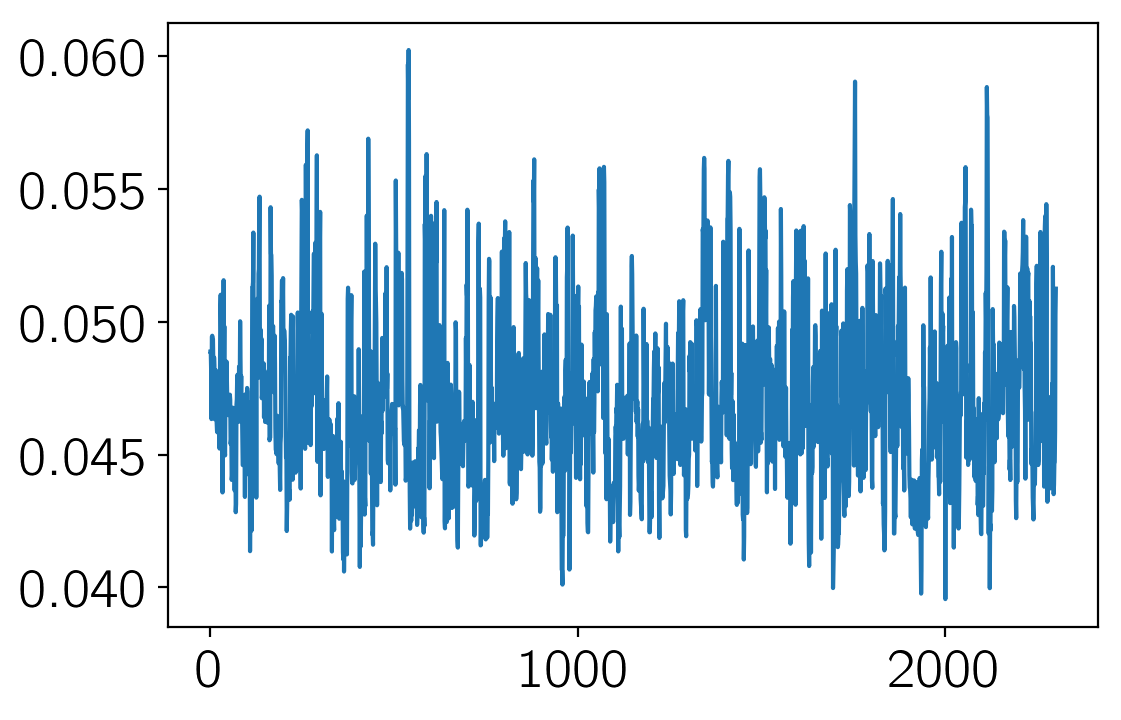

In [10]:
plt.plot(burnin["r"][:, 1])

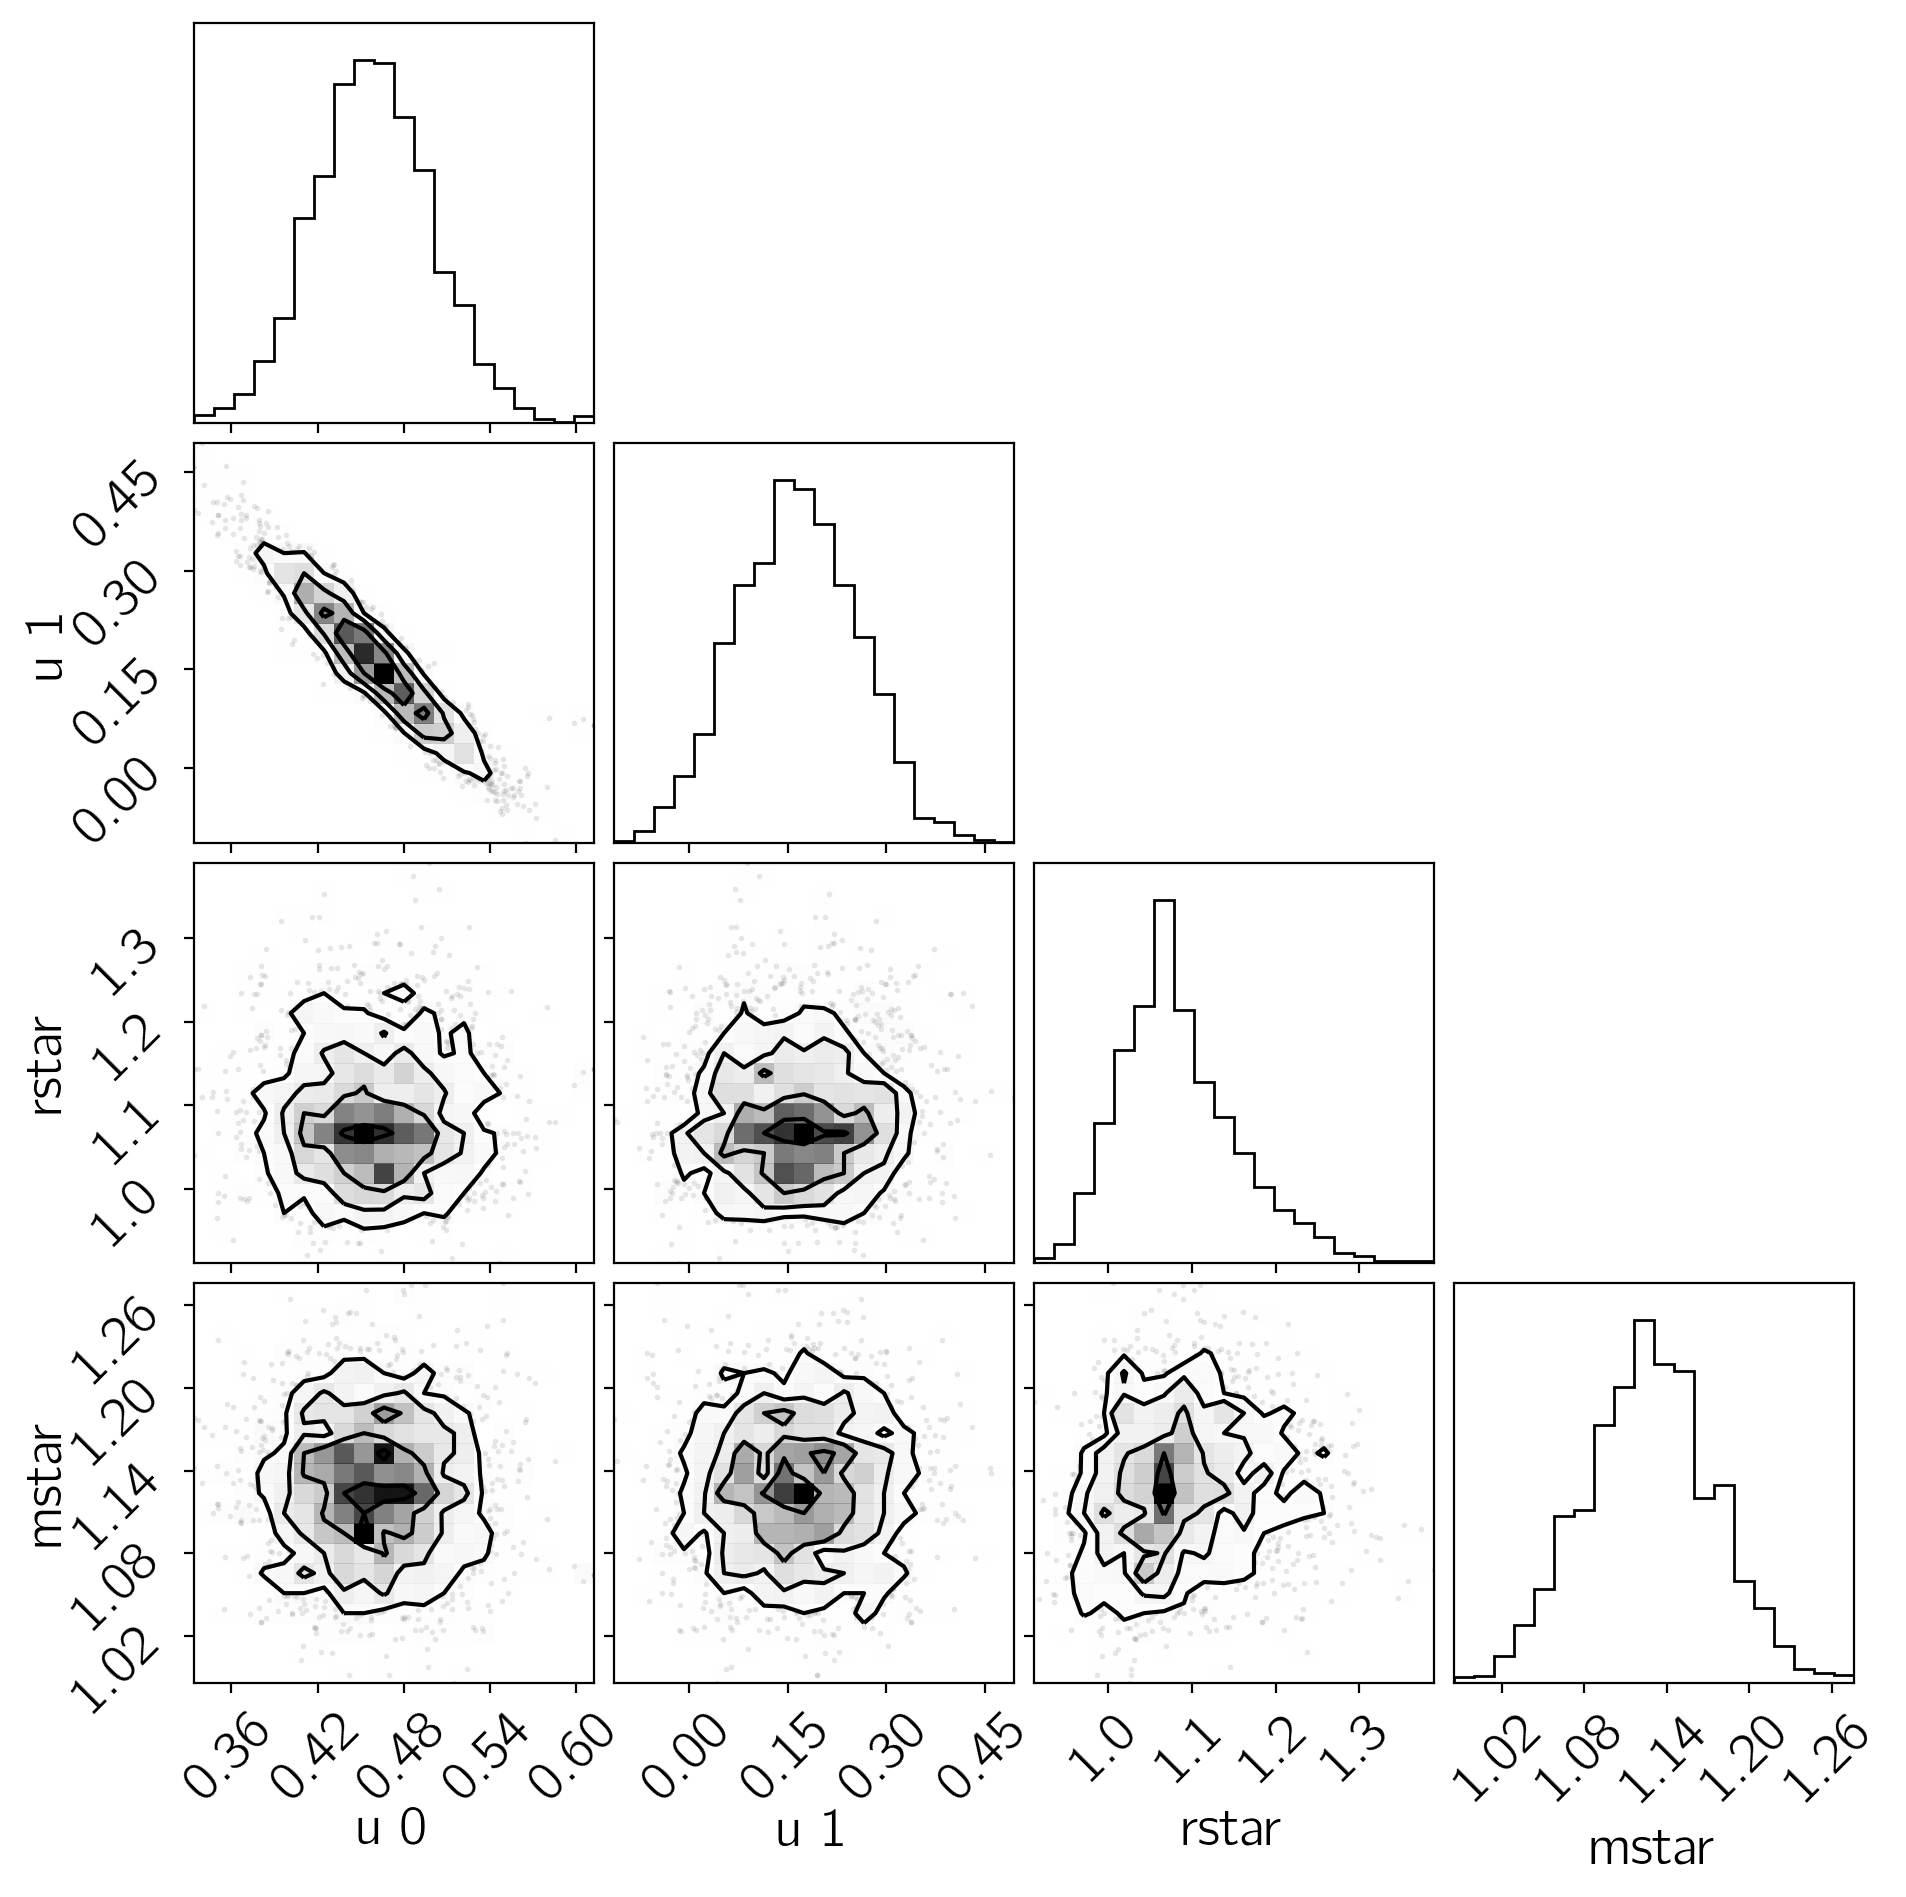

In [11]:
samples = pm.trace_to_dataframe(burnin, varnames=["u", "rstar", "mstar"])
samples.columns = [k.replace("_", " ") for k in samples.columns]
corner.corner(samples);

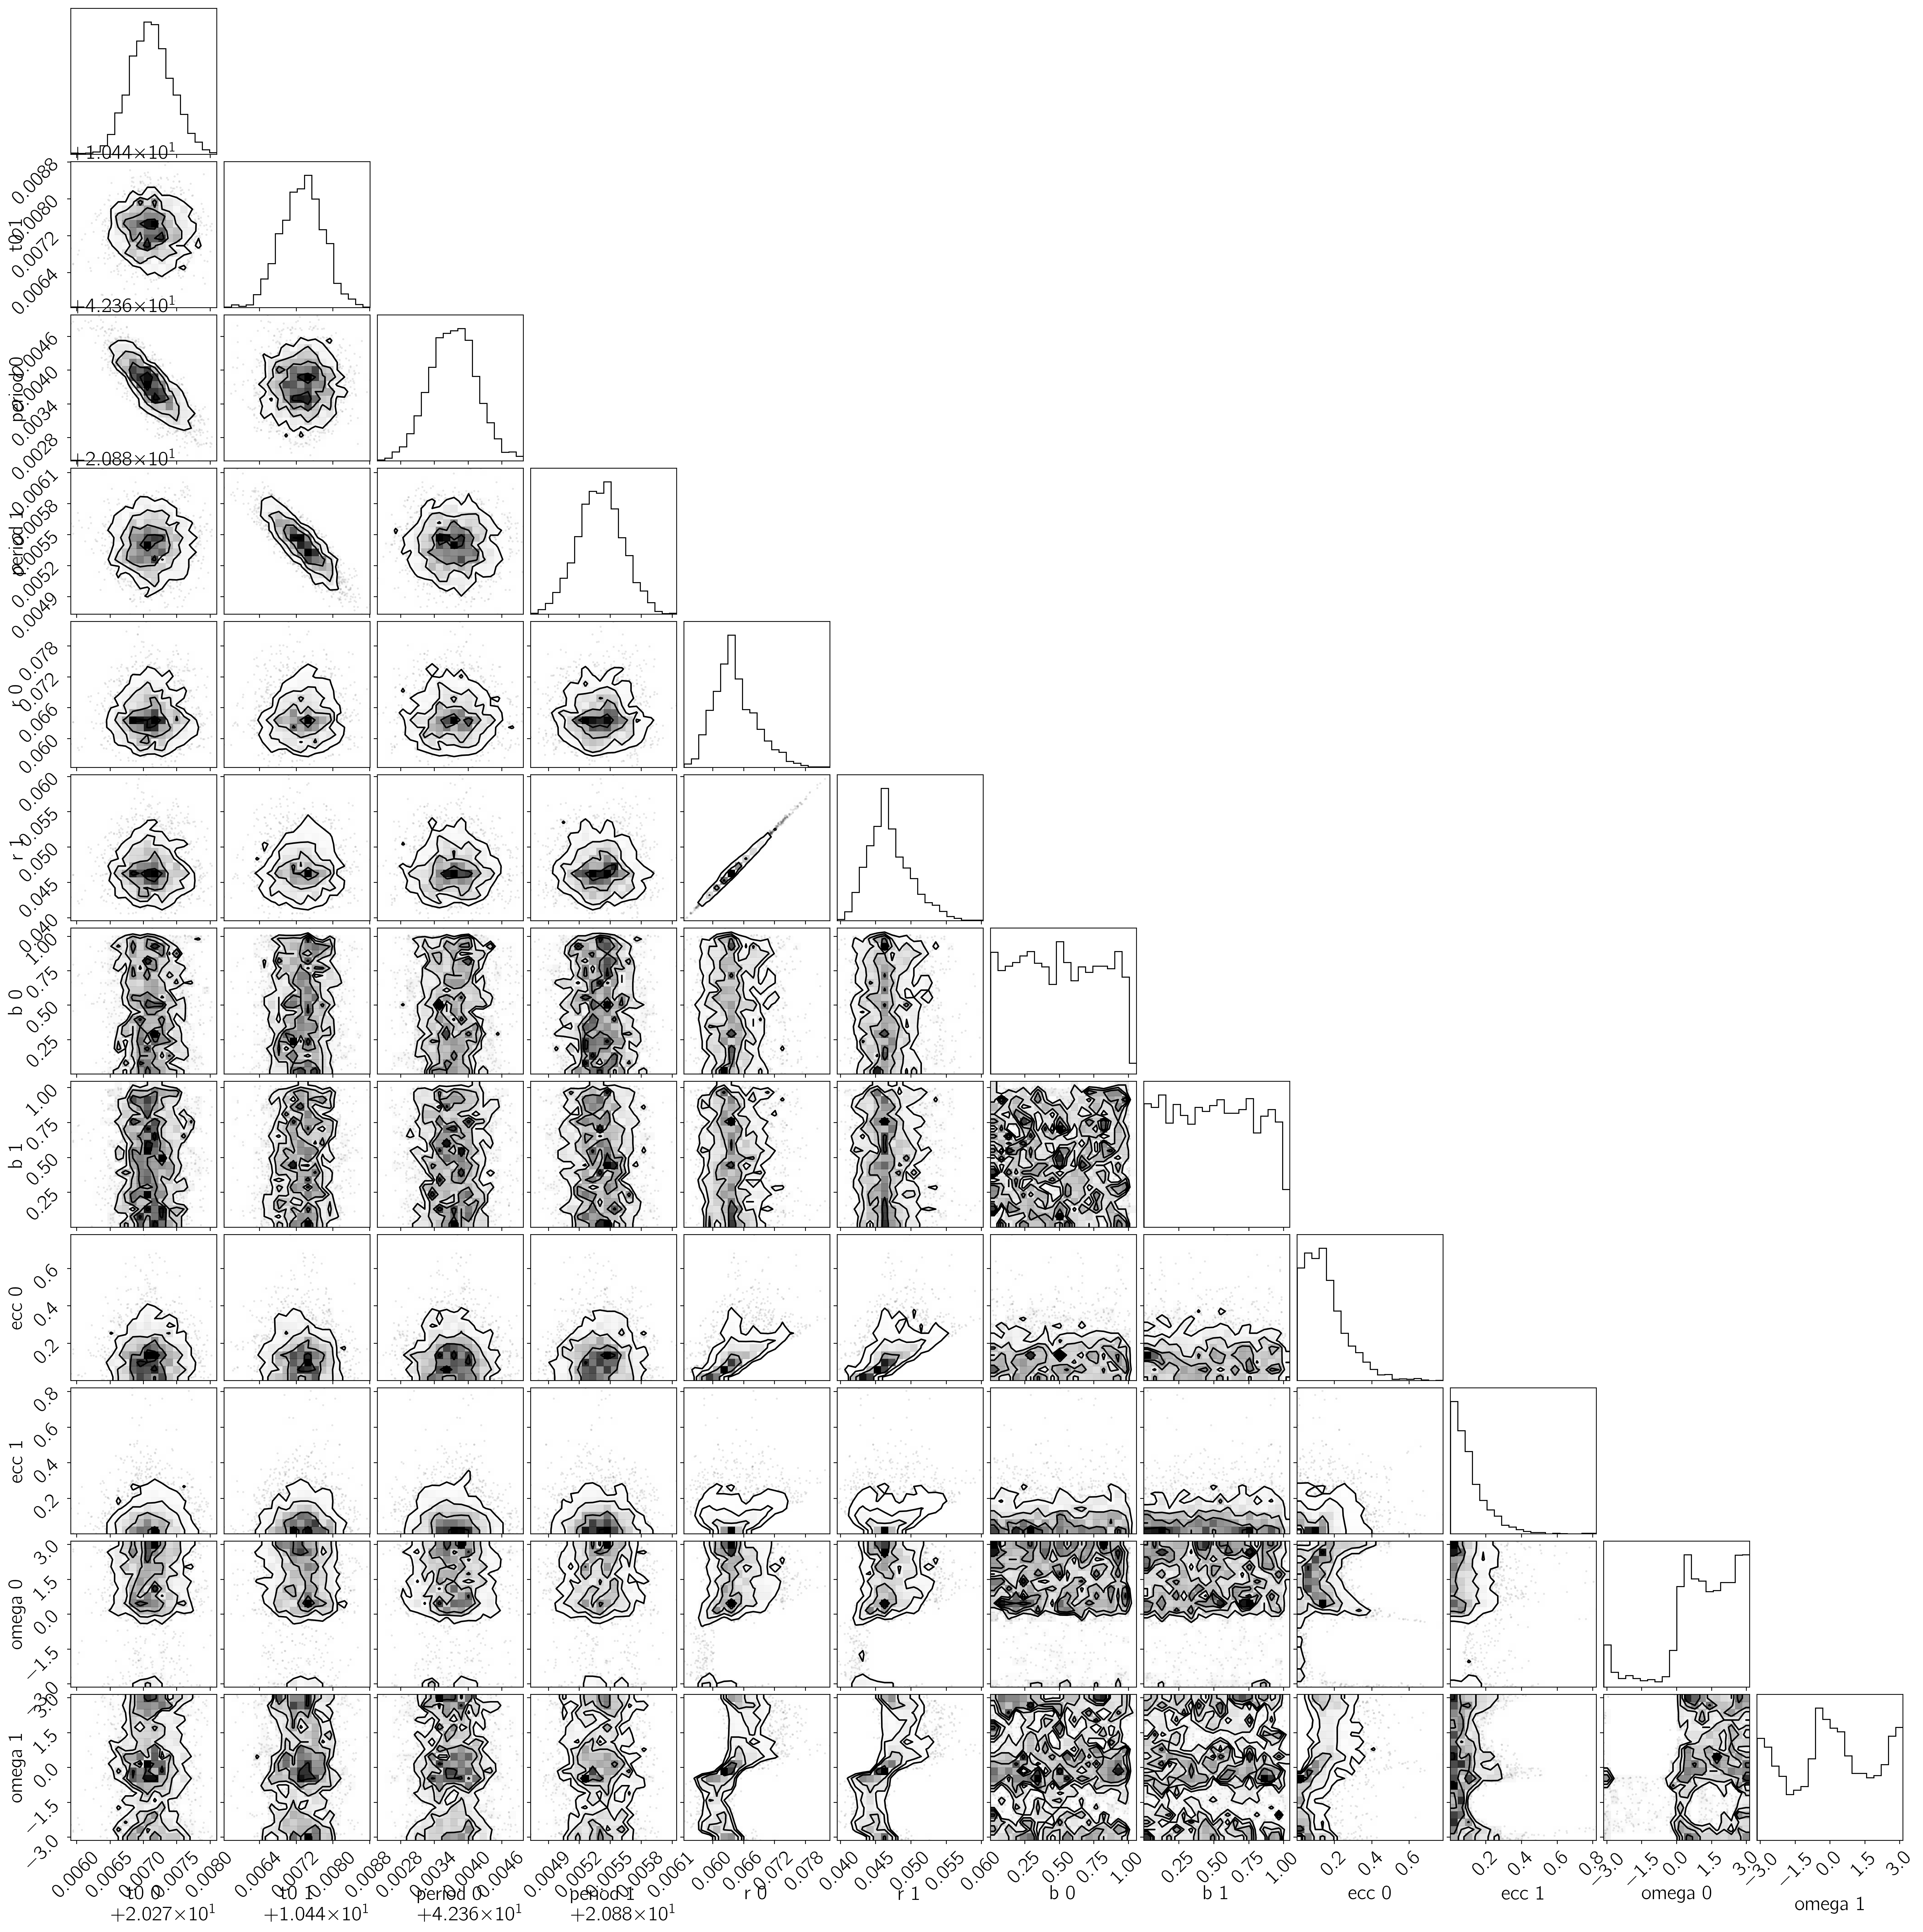

In [12]:
samples = pm.trace_to_dataframe(burnin, varnames=["t0", "period", "r", "b", "ecc", "omega"])
samples.columns = [k.replace("_", " ") for k in samples.columns]
corner.corner(samples);

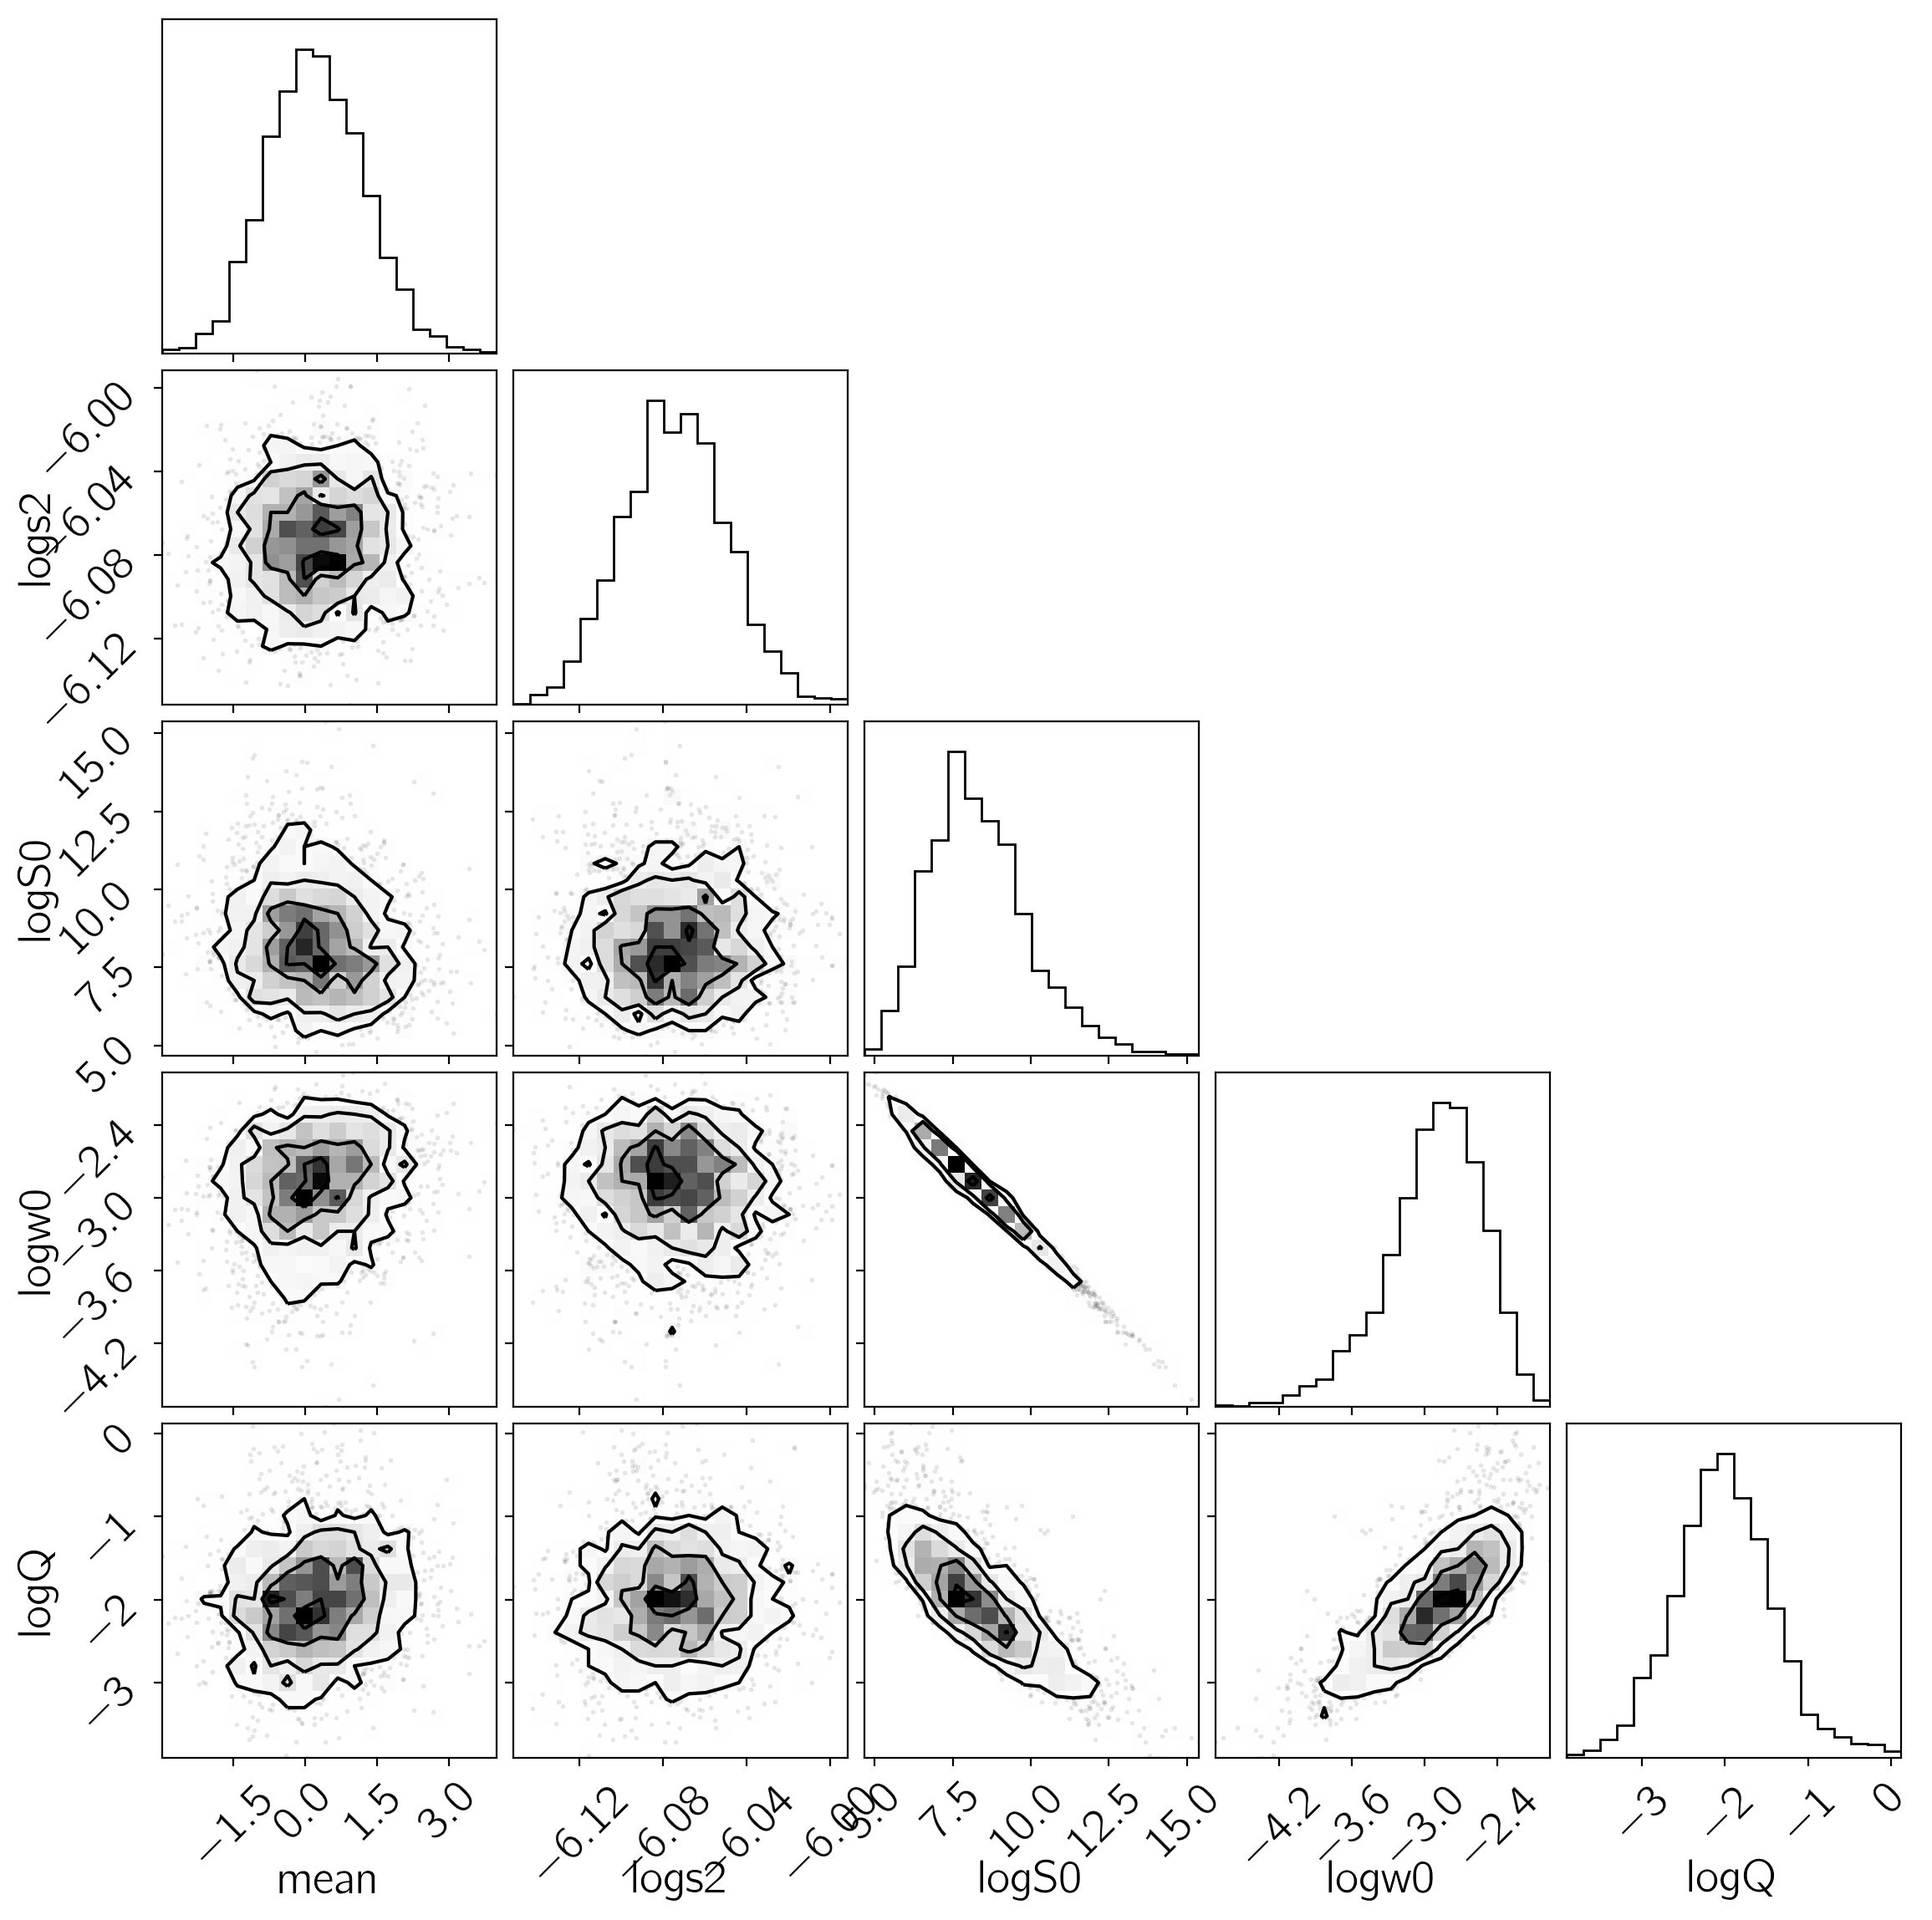

In [13]:
samples = pm.trace_to_dataframe(burnin, varnames=["mean", "logs2", "logS0", "logw0", "logQ"])
samples.columns = [k.replace("_", " ") for k in samples.columns]
corner.corner(samples);

In [ ]:
                0.5*self.S0*self.w0*Q*tt.stack([1.0+1.0/f, 1.0-1.0/f]),


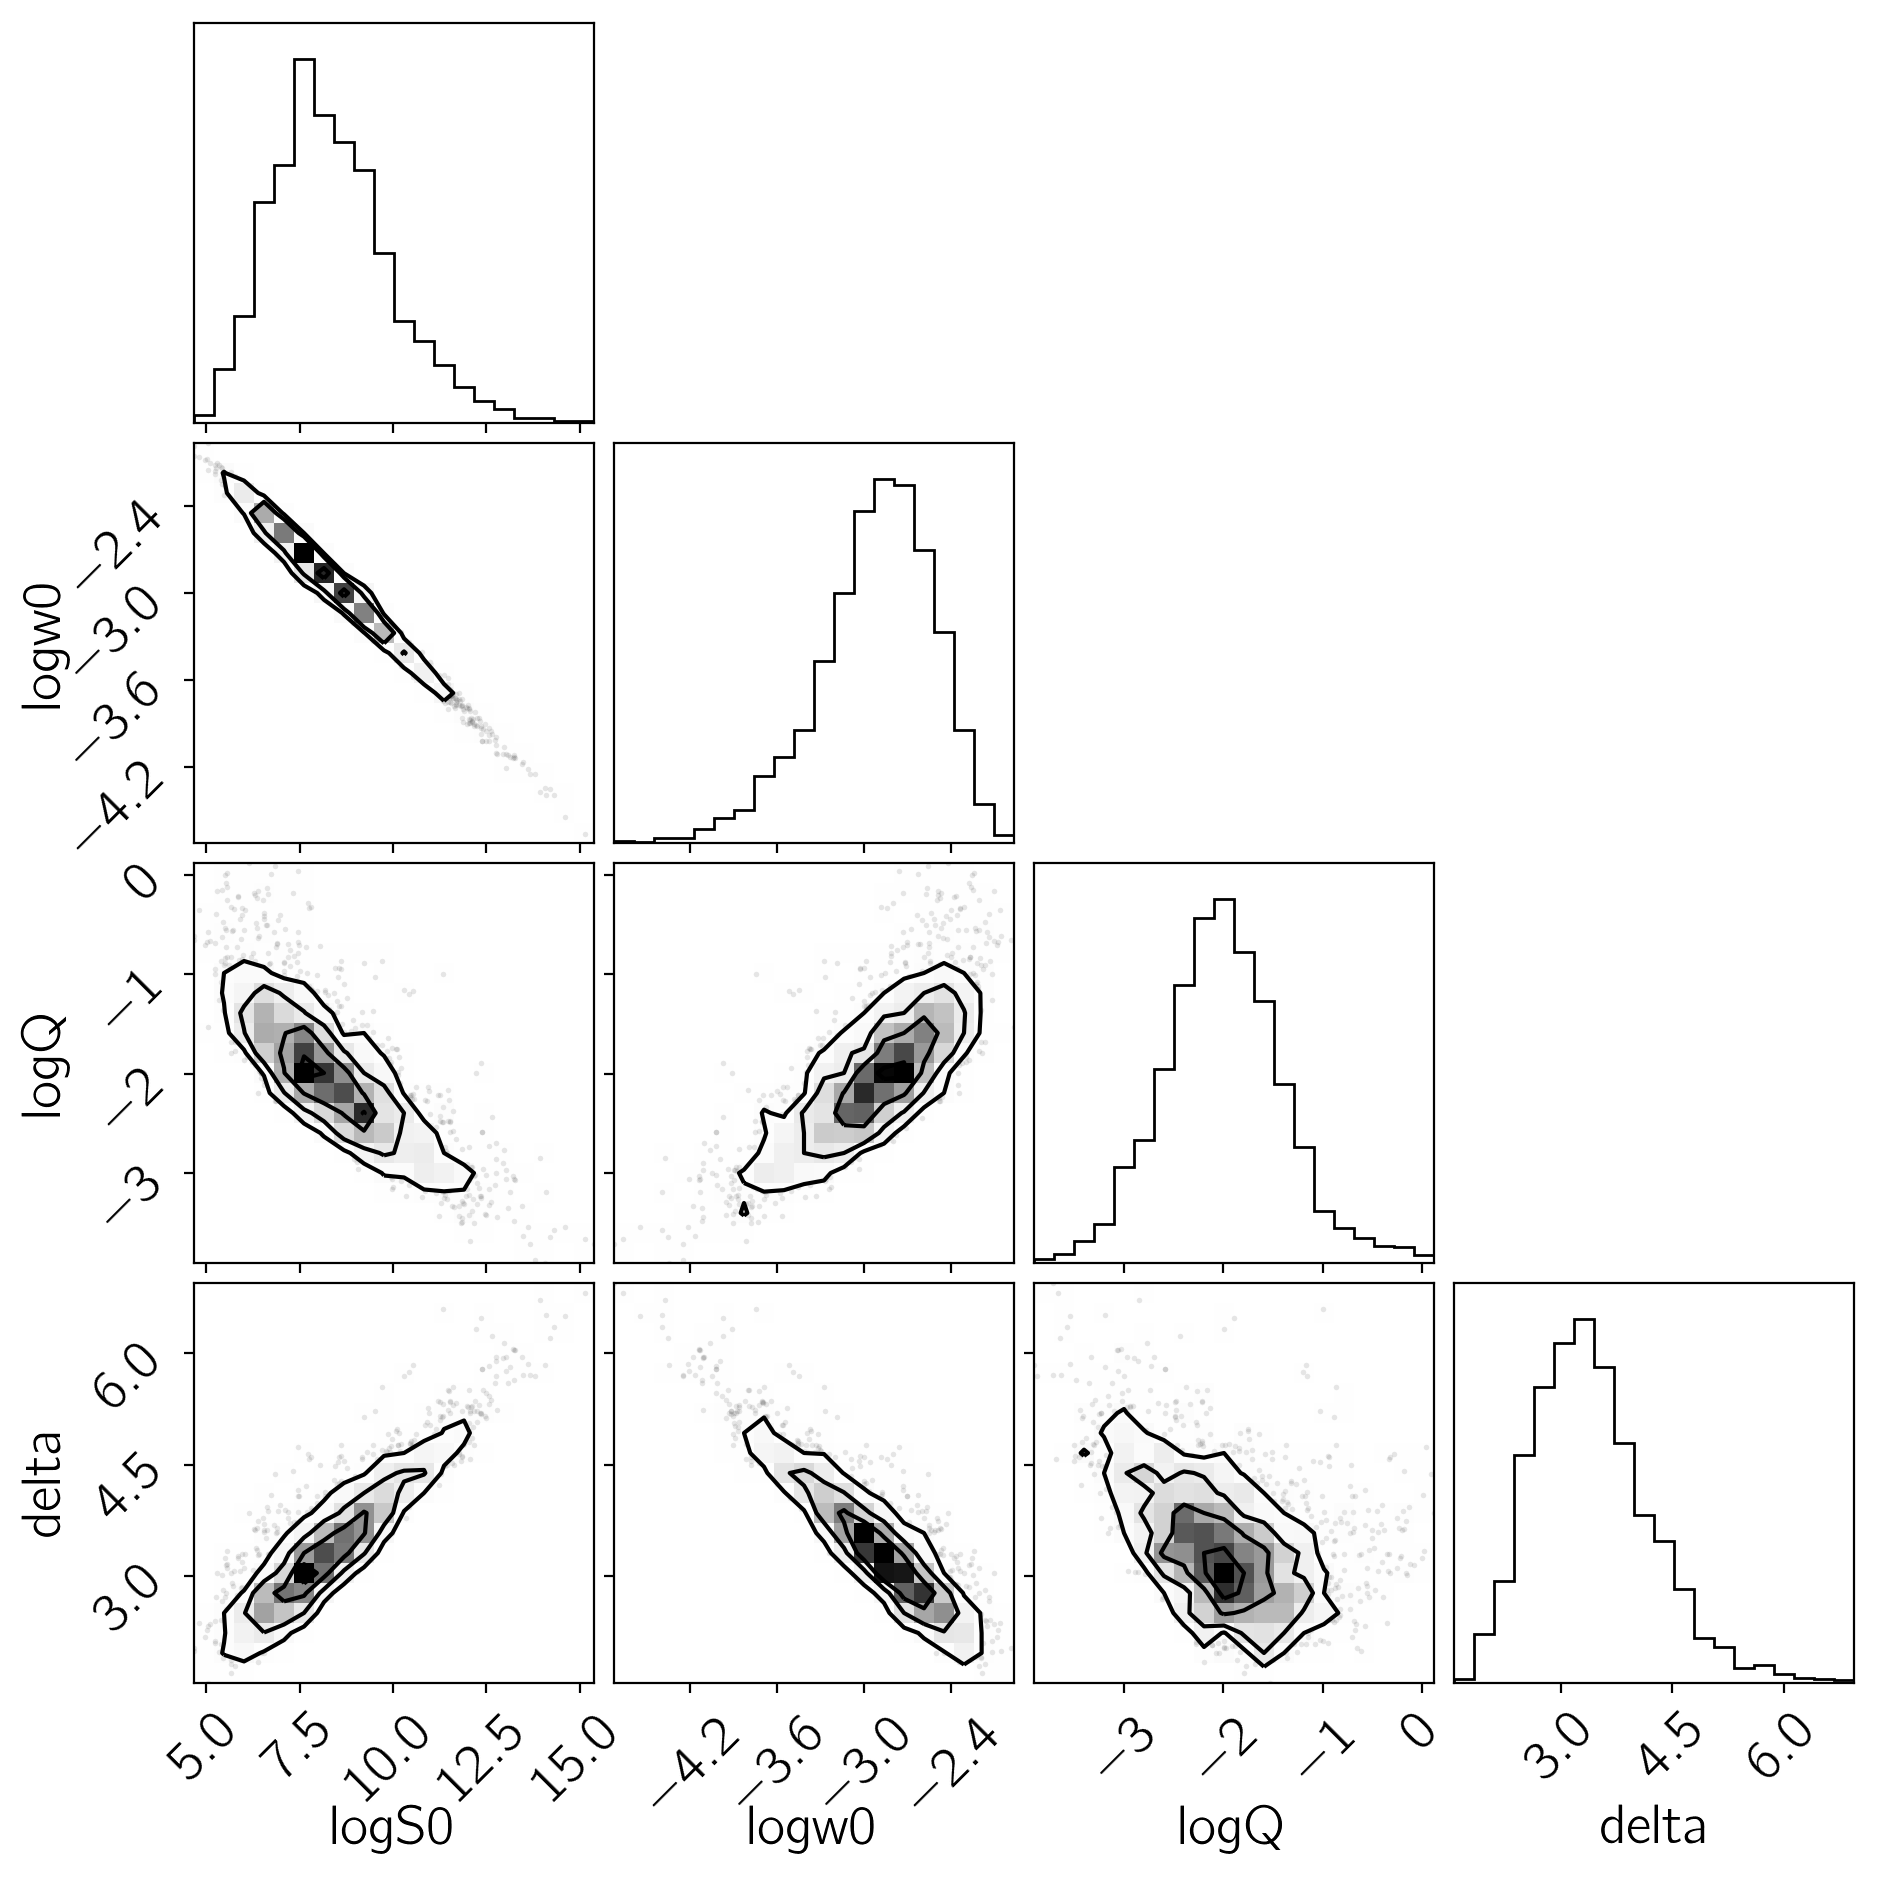

In [17]:
samples = pm.trace_to_dataframe(burnin, varnames=["logS0", "logw0", "logQ"])
samples["delta"] = samples.logS0 + samples.logw0 + samples.logQ
corner.corner(samples);

In [14]:
with model:
    trace = schedule.sample(draws=2000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logQ, logw0, logS0, logs2, omega, ecc, rb, logperiod, t0, rstar, mstar, u, mean]
Sampling 2 chains:  80%|████████  | 3285/4100 [5:24:51<3:42:30, 16.38s/draws]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/dforeman/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-6b9cae1d1b36>", line 2, in <module>
    trace = schedule.sample(draws=2000)
  File "/Users/dforeman/research/projects/dfm/exoplanet/exoplanet/sampling.py", line 160, in sample
    return pm.sample(start=start, step=step, **kwargs)
  File "/Users/dforeman/anaconda/lib/python3.6/site-packages/pymc3/sampling.py", line 472, in sample
    trace = trace[discard:]
  File "/Users/dforeman/anaconda/lib/python3.6/site-packages/pymc3/backends/base.py", line 292, in __getitem__
    return self._slice(idx)
  File "/Users/dforeman/anaconda/lib/python3.6/site-packages/pymc3/backends/base.py", line 496, in _slice
    new_traces = [trace._slice(slice) for trace in self._straces.values()]
  File "/Users/dforeman/anaconda/lib/python3.6/site-packages/pymc3/backends/base.py", 

KeyboardInterrupt: 

In [ ]:
samples = pm.trace_to_dataframe(trace, varnames=["u", "rstar", "mstar"])
samples.columns = [k.replace("_", " ") for k in samples.columns]
corner.corner(samples);

In [ ]:
samples = pm.trace_to_dataframe(trace, varnames=["t0", "period", "r", "b", "ecc", "omega"])
samples.columns = [k.replace("_", " ") for k in samples.columns]
corner.corner(samples);

In [ ]:
samples = pm.trace_to_dataframe(trace, varnames=["mean", "logs2", "logS0", "logw0", "logQ"])
samples.columns = [k.replace("_", " ") for k in samples.columns]
corner.corner(samples);

In [ ]:
with model:
    plt.plot(x[mask], y[mask] - np.median(trace["gp"], axis=0), ".k")
        
    plt.plot(x[mask], np.median(trace["transit"], axis=0))
#     plt.plot(x[mask], exoplanet.utils.eval_in_model(model.transit, soln))
#     plt.plot(x[mask], exoplanet.utils.eval_in_model(model.gp, soln))
    
#     plt.figure()
# #     plt.plot(x[mask], exoplanet.utils.eval_in_model(model.resid))
#     plt.plot(x[mask], exoplanet.utils.eval_in_model(model.resid, soln))